# **Klasifikasi Jenis Sayur (Kelompok 7)**

Anggota Kelompok:
- Ahmad Dzul Fadhli Hannan
- Gilang Purnomo
- Muhammad Firmandika Jati Kusuma
- Rafi Abiyyu Airlangga

### **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import time
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
from joblib import Parallel, delayed

In [ ]:
# set style untuk plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### **Load Dataset**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'vegetable-image-dataset' dataset.
Path to dataset files: /kaggle/input/vegetable-image-dataset


In [ ]:
train_dir = r"/kaggle/input/vegetable-image-dataset/Vegetable Images/train"
# train_dir = r"D:\KULIAH 5\Pembelajaran Mesin\week 12\Vegetable Images\train"

class_names = os.listdir(train_dir)
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Class names: ['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']
Number of classes: 15


In [ ]:
train_counts = []

for class_name in class_names:
    path = os.path.join(train_dir, class_name)
    train_counts.append(len(os.listdir(path)))

df_counts = pd.DataFrame({
    'Nama Kelas/Sayur': class_names,
    'Jumlah Gambar': train_counts
}).sort_values(by='Jumlah Gambar', ascending=False).reset_index(drop=True)

print(df_counts)

   Nama Kelas/Sayur  Jumlah Gambar
0          Broccoli           1000
1          Capsicum           1000
2      Bottle_Gourd           1000
3            Radish           1000
4            Tomato           1000
5           Brinjal           1000
6           Pumpkin           1000
7            Carrot           1000
8            Papaya           1000
9           Cabbage           1000
10     Bitter_Gourd           1000
11      Cauliflower           1000
12             Bean           1000
13         Cucumber           1000
14           Potato           1000


### **1. Pra Pengolahan Data**

Preprocessing dan pembersihan data gambar
- Cropping ke bagian tengah
- Resizing ke ukuran konsisten (128x128)
- Rotasi untuk augmentasi
- Image enhancement (contrast/brightness, noise removal, glare removal)
- Histogram equalization
- Normalisasi nilai pixel

In [ ]:
def preprocess_image(img_path, img_size=(128, 128)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # crop tengah
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_x = w//2 - min_dim//2
    start_y = h//2 - min_dim//2
    img_cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]

    # resize ke ukuran konsisten
    img_resized = cv2.resize(img_cropped, img_size)

    # rotasi untuk augmentasi
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((img_size[0]//2, img_size[1]//2), angle, 1)
    img_rotated = cv2.warpAffine(img_resized, M, img_size)

    # IMAGE ENHANCEMENT
    # contrast dan brightness correction
    img_enhanced = cv2.convertScaleAbs(img_rotated, alpha=1.2, beta=10)

    # noise removal
    img_denoised = cv2.GaussianBlur(img_enhanced, (3, 3), 0)

    # glare removal dengan histogram equalization
    yuv = cv2.cvtColor(img_denoised, cv2.COLOR_RGB2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    img_final = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

    # normalisasi
    img_final = img_final / 255.0

    return img_final

In [ ]:
if __name__ == "__main__":
    # Ganti 'path/ke/folder/training' dengan path direktori data training Anda
    train_dir = 'path/ke/folder/training'

    # Periksa apakah direktori ada
    if os.path.isdir(train_dir):
        # Muat dan proses seluruh dataset
        X_train, y_train = load_and_preprocess_dataset(train_dir)

        if X_train is not None and y_train is not None:
            print("\n======================================")
            print("Pemuatan dan Pra-pemrosesan Selesai!")
            print(f"Total gambar yang diproses: {len(X_train)}")
            print(f"Total label yang dibuat   : {len(y_train)}")
            print(f"Shape dari array gambar (X_train): {X_train.shape}")
            print(f"Shape dari array label (y_train)  : {y_train.shape}")
            print(f"Label unik: {np.unique(y_train)}")
            print("======================================")
    else:
        print(f"Error: Direktori '{train_dir}' tidak ditemukan.")
        print("Pastikan untuk mengganti 'path/ke/folder/training' dengan path yang benar.")


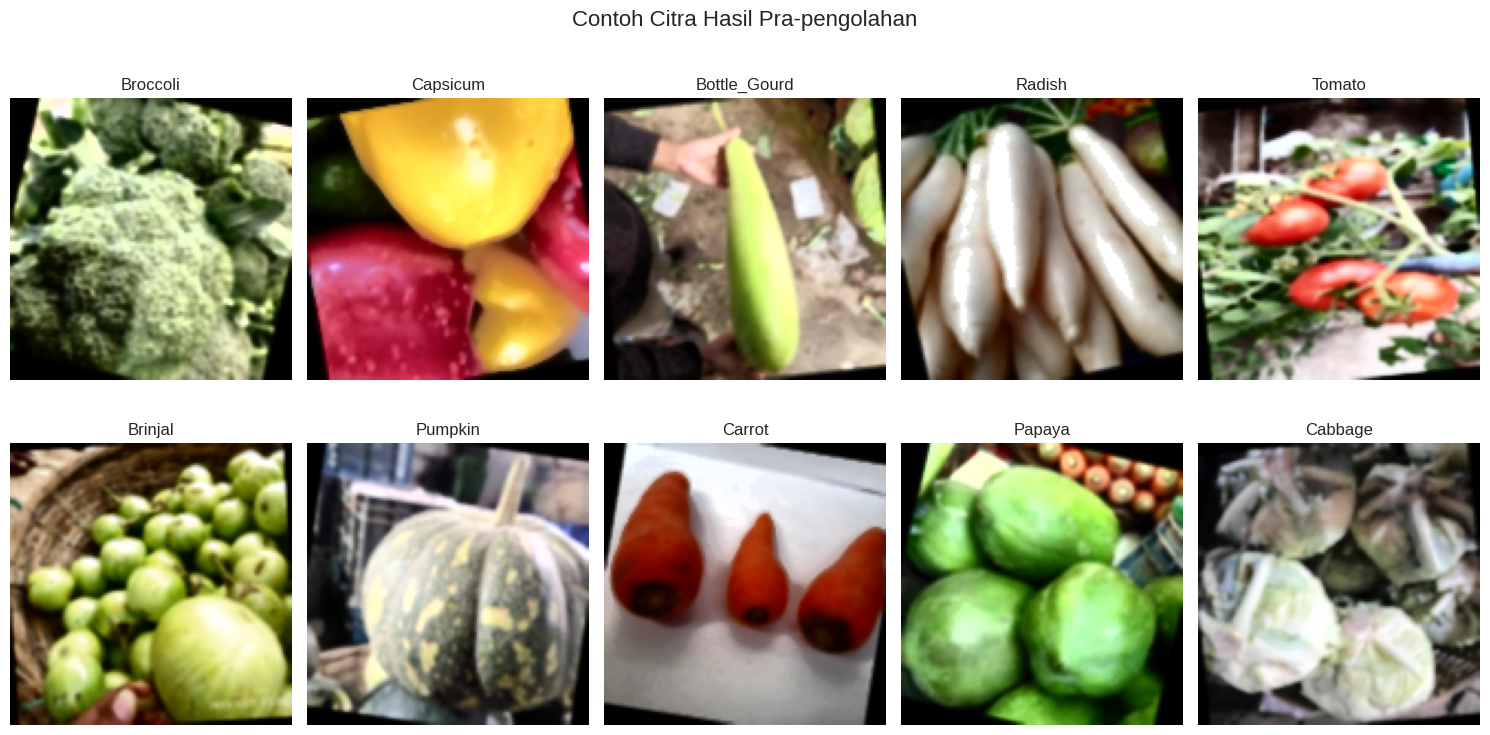

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(len(images_for_display)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_for_display[i])
    plt.title(f'{class_names[labels_for_display[i]]}')
    plt.axis('off')

plt.suptitle('Contoh Citra Hasil Pra-pengolahan', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
del images_for_display
del labels_for_display

### **2. Ekstraksi Fitur**

Mengekstrak fitur warna dan tekstur dari gambar yang sudah dipreprocessing
- Fitur warna: HSV color histogram (6 fitur: H_mean, S_mean, V_mean, H_std, S_std, V_std)
- Fitur tekstur: Local Binary Pattern (LBP) dengan 32 bin histogram
- Total fitur: 38 fitur per gambar

In [ ]:
def extract_features(images):
    color_features = []
    texture_features = []

    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)

        hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
        h_mean, s_mean, v_mean = np.mean(hsv, axis=(0,1))
        h_std, s_std, v_std = np.std(hsv, axis=(0,1))
        color_feat = [h_mean, s_mean, v_mean, h_std, s_std, v_std]

        # fitur tekstur
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

        # implementasi LBP
        P = 8
        R = 1
        lbp = local_binary_pattern(gray, P=P, R=R, method='default')

        # histogram LBP sebagai fitur tekstur
        hist, _ = np.histogram(lbp.ravel(), bins=32, range=(0, 256))
        hist = hist / hist.sum()

        color_features.append(color_feat)
        texture_features.append(hist)

    color_features = np.array(color_features)
    texture_features = np.array(texture_features)

    return np.concatenate([color_features, texture_features], axis=1)

In [ ]:
all_image_paths = []
all_image_labels = []

for idx, class_name in enumerate(class_names):
    path = os.path.join(train_dir, class_name)
    img_files = os.listdir(path)
    for img_file in img_files:
        all_image_paths.append(os.path.join(path, img_file))
        all_image_labels.append(idx)

In [ ]:
X_features = []
y_train = []

for i in tqdm(range(len(all_image_paths)), desc="Processing Images"):
    img_path = all_image_paths[i]
    label = all_image_labels[i]

    processed_img = preprocess_image(img_path)

    if processed_img is not None:
        feature_vector = extract_features([processed_img])[0]

        X_features.append(feature_vector)
        y_train.append(label)

X_features = np.array(X_features)
y_train = np.array(y_train)

print(f"Bentuk matriks fitur: {X_features.shape}")
print(f"Bentuk label: {y_train.shape}")

Processing Images: 100%|██████████| 15000/15000 [04:35<00:00, 54.48it/s]

Bentuk matriks fitur: (15000, 38)
Bentuk label: (15000,)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Setelah PCA: {X_pca.shape}")
print(f"Variance terjelaskan: {np.sum(pca.explained_variance_ratio_):.4f}")

Setelah PCA: (15000, 23)
Variance terjelaskan: 0.9508


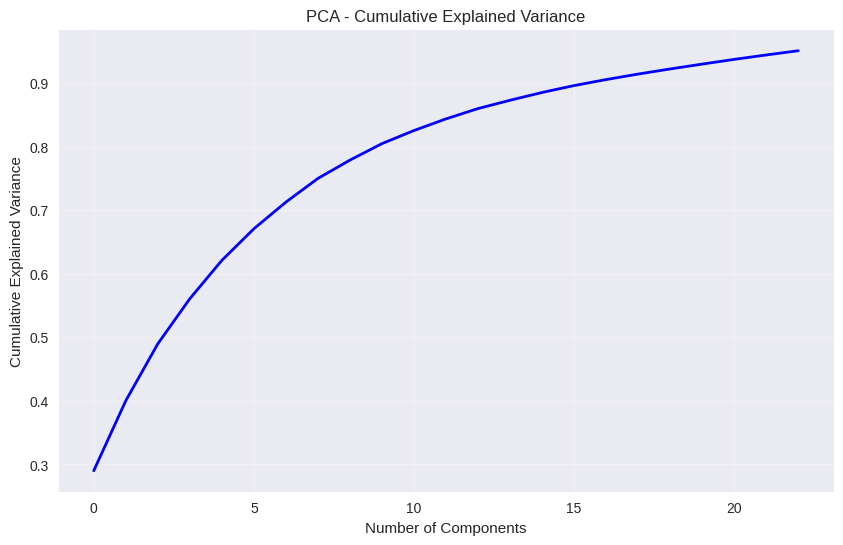

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'b-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.show()

### **3. Pembuatan Data Latih dan Data Uji**

Mempersiapkan data untuk training dan testing
- Menggunakan 15k data dari training dataset asli
- Metode splitting yang digunakan:
  - Hold-Out Validation: 70:30, 80:20, 90:10
  - Cross-Validation: k-fold dengan k=5
- Setiap split menggunakan stratifikasi untuk menjaga distribusi kelas

#### **3.1 Ringkasan Jumlah Data per Split**

In [ ]:
models = {
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000)
}

In [ ]:
splits = [(0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
results = {}

for train_size, test_size in splits:
    print(f"\n{'='*50}")
    print(f"SPLIT {int(train_size*100)}:{int(test_size*100)}")
    print(f"{'='*50}")

    # split data
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_pca, y_train,
        train_size=train_size,
        stratify=y_train,
        random_state=42
    )

    results_split = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()

        # training
        model.fit(X_tr, y_tr)

        # prediction
        y_pred = model.predict(X_te)
        training_time = time.time() - start_time

        # metrics
        accuracy = accuracy_score(y_te, y_pred)
        precision = precision_score(y_te, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_te, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_te, y_pred, average='weighted', zero_division=0)

        results_split[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time
        }

        print(f"{name}:")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print(f"Time:      {training_time:.2f}s")

    results[f"{int(train_size*100)}:{int(test_size*100)}"] = results_split


SPLIT 70:30

Training SVM...
SVM:
Accuracy:  0.8949
Precision: 0.8958
Recall:    0.8949
F1-Score:  0.8951
Time:      4.73s

Training Random Forest...
Random Forest:
Accuracy:  0.8647
Precision: 0.8648
Recall:    0.8647
F1-Score:  0.8643
Time:      7.09s

Training KNN...
KNN:
Accuracy:  0.8989
Precision: 0.8997
Recall:    0.8989
F1-Score:  0.8985
Time:      0.36s

Training Logistic Regression...
Logistic Regression:
Accuracy:  0.6340
Precision: 0.6319
Recall:    0.6340
F1-Score:  0.6320
Time:      2.37s

SPLIT 80:20

Training SVM...
SVM:
Accuracy:  0.8953
Precision: 0.8969
Recall:    0.8953
F1-Score:  0.8956
Time:      4.69s

Training Random Forest...
Random Forest:
Accuracy:  0.8693
Precision: 0.8694
Recall:    0.8693
F1-Score:  0.8690
Time:      8.03s

Training KNN...
KNN:
Accuracy:  0.9087
Precision: 0.9099
Recall:    0.9087
F1-Score:  0.9086
Time:      0.23s

Training Logistic Regression...
Logistic Regression:
Accuracy:  0.6293
Precision: 0.6281
Recall:    0.6293
F1-Score:  0.6279

#### **3.2 Cross-Validation dengan k=5**

In [ ]:
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nCross-validation untuk {name}...")

    # CV untuk multiple metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    cv_scores = cross_val_score(model, X_pca, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    cv_results[name] = {
        'mean_accuracy': np.mean(cv_scores),
        'std_accuracy': np.std(cv_scores),
        'all_scores': cv_scores
    }

    print(f"   {name} - CV Accuracy: {cv_results[name]['mean_accuracy']:.4f} (±{cv_results[name]['std_accuracy']:.4f})")
    print(f"   Semua scores: {[f'{score:.4f}' for score in cv_scores]}")


Cross-validation untuk SVM...
   SVM - CV Accuracy: 0.8984 (±0.0104)
   Semua scores: ['0.9033', '0.8820', '0.8933', '0.9003', '0.9130']

Cross-validation untuk Random Forest...
   Random Forest - CV Accuracy: 0.8709 (±0.0083)
   Semua scores: ['0.8720', '0.8653', '0.8697', '0.8617', '0.8860']

Cross-validation untuk KNN...
   KNN - CV Accuracy: 0.9021 (±0.0064)
   Semua scores: ['0.9007', '0.8927', '0.9003', '0.9043', '0.9123']

Cross-validation untuk Logistic Regression...
   Logistic Regression - CV Accuracy: 0.6317 (±0.0121)
   Semua scores: ['0.6467', '0.6160', '0.6203', '0.6327', '0.6430']


### **4. Pembuatan Model**

Training model machine learning (non-deep learning)
- Model yang digunakan: SVM, Random Forest, KNN, Logistic Regression
- Normalisasi fitur menggunakan StandardScaler
- Reduksi dimensi menggunakan PCA (optional, untuk performa lebih baik)
- Hyperparameter Tuning untuk setiap model
- Menyimpan model dalam bentuk file pkl

#### **4.1 Inisialisasi Model dan Training dengan Hold-Out Validation**

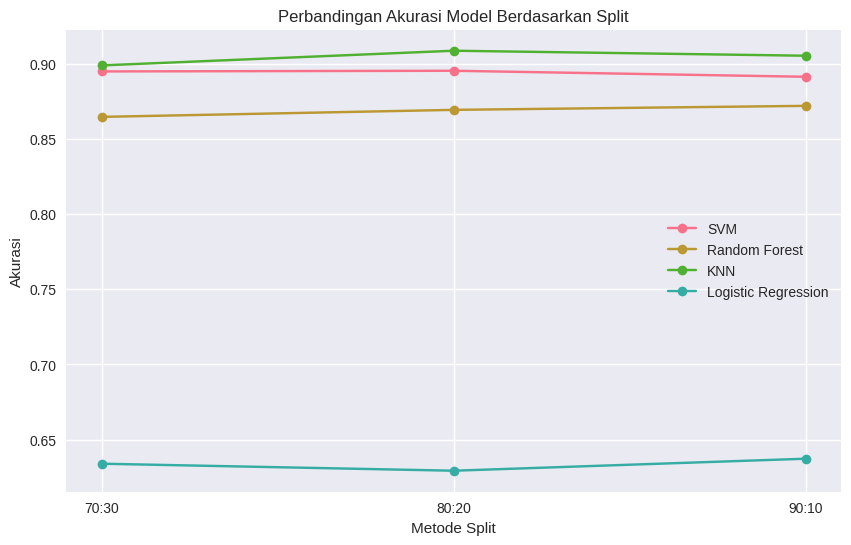

In [ ]:
plt.figure(figsize=(10,6))
for name in models.keys():
    accs = [results[split][name]['accuracy'] for split in results.keys()]
    plt.plot(['70:30','80:20','90:10'], accs, marker='o', label=name)
plt.title("Perbandingan Akurasi Model Berdasarkan Split")
plt.xlabel("Metode Split")
plt.ylabel("Akurasi")
plt.legend()
plt.grid(True)
plt.show()


#### **4.2 Hyperparameter Tuning untuk Setiap Model**

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y_train, train_size=0.8, stratify=y_train, random_state=42)

In [ ]:
# tuning untuk Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_tr, y_tr)
print("Random Forest - Best params:", rf_grid.best_params_)
print("Random Forest - Best score:", rf_grid.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest - Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Best score: 0.8585833333333334


In [ ]:
# tuning untuk SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(
    SVC(random_state=42),
    svm_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_tr, y_tr)
print("SVM - Best params:", svm_grid.best_params_)
print("SVM - Best score:", svm_grid.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
SVM - Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVM - Best score: 0.927


In [ ]:
# tuning untuk KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    knn_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
knn_grid.fit(X_tr, y_tr)
print("KNN - Best params:", knn_grid.best_params_)
print("KNN - Best score:", knn_grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
KNN - Best params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
KNN - Best score: 0.891


In [ ]:
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

In [ ]:
# tuning untuk Logistic Regression
logreg_grid = GridSearchCV(
    LogisticRegression(random_state=42, n_jobs=-1, solver='liblinear'),
    logreg_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
logreg_grid.fit(X_tr, y_tr)
print("Logistic Regression - Best params:", logreg_grid.best_params_)
print("Logistic Regression - Best score:", logreg_grid.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Logistic Regression - Best params: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression - Best score: 0.63125


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# bandingkan keempat model dan pilih yang terbaik
model_scores = {
    'Random Forest': rf_grid.best_score_,
    'SVM': svm_grid.best_score_,
    'KNN': knn_grid.best_score_,
    'Logistic Regression': logreg_grid.best_score_
}

best_model_name = max(model_scores, key=model_scores.get)
best_score = model_scores[best_model_name]

# assign model terbaik
if best_model_name == 'Random Forest':
    best_model = rf_grid.best_estimator_
elif best_model_name == 'SVM':
    best_model = svm_grid.best_estimator_
elif best_model_name == 'KNN':
    best_model = knn_grid.best_estimator_
else:
    best_model = logreg_grid.best_estimator_

print(f"\nPerbandingan Model:")
for model, score in model_scores.items():
    print(f"   {model}: {score:.4f}")
print(f"Model Terbaik: {best_model_name} (Score: {best_score:.4f})")


Perbandingan Model:
   Random Forest: 0.8586
   SVM: 0.9270
   KNN: 0.8910
   Logistic Regression: 0.6312
Model Terbaik: SVM (Score: 0.9270)


### **5. Evaluasi Model**

Mengevaluasi performa model berdasarkan metrik dan visualisasi
- Metrik evaluasi: Akurasi, Presisi, Recall, F1-Score
- Confusion Matrix untuk model terbaik
- Grafik perbandingan performa model berdasarkan berbagai split

In [ ]:
best_model.fit(X_tr, y_tr)
y_pred_best = best_model.predict(X_te)

print(f"\nEVALUASI MODEL TERBAIK ({best_model_name}):")
print(f"Accuracy:  {accuracy_score(y_te, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_te, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_te, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_te, y_pred_best, average='weighted', zero_division=0):.4f}")


EVALUASI MODEL TERBAIK (SVM):
Accuracy:  0.9403
Precision: 0.9406
Recall:    0.9403
F1-Score:  0.9403


In [ ]:
print("\n--- EVALUASI MODEL RANDOM FOREST ---")
rf_model = rf_grid.best_estimator_
rf_model.fit(X_tr, y_tr)
y_pred_rf = rf_model.predict(X_te)

print(f"Accuracy:  {accuracy_score(y_te, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_te, y_pred_rf, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_te, y_pred_rf, average='weighted', zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_te, y_pred_rf, average='weighted', zero_division=0):.4f}")



--- EVALUASI MODEL RANDOM FOREST ---
Accuracy:  0.8720
Precision: 0.8726
Recall:    0.8720
F1-Score:  0.8719


In [ ]:
print("\n--- EVALUASI MODEL KNN ---")
knn_model = knn_grid.best_estimator_
knn_model.fit(X_tr, y_tr)
y_pred_knn = knn_model.predict(X_te)

print(f"Accuracy:  {accuracy_score(y_te, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_te, y_pred_knn, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_te, y_pred_knn, average='weighted', zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_te, y_pred_knn, average='weighted', zero_division=0):.4f}")


--- EVALUASI MODEL KNN ---
Accuracy:  0.9110
Precision: 0.9118
Recall:    0.9110
F1-Score:  0.9107


In [ ]:
print("\n--- EVALUASI MODEL REGRESI LOGISTIK ---")
logreg_model = logreg_grid.best_estimator_
logreg_model.fit(X_tr, y_tr)
y_pred_logreg = logreg_model.predict(X_te)

print(f"Accuracy:  {accuracy_score(y_te, y_pred_logreg):.4f}")
print(f"Precision: {precision_score(y_te, y_pred_logreg, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_te, y_pred_logreg, average='weighted', zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_te, y_pred_logreg, average='weighted', zero_division=0):.4f}")


--- EVALUASI MODEL REGRESI LOGISTIK ---
Accuracy:  0.6290
Precision: 0.6278
Recall:    0.6290
F1-Score:  0.6275


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


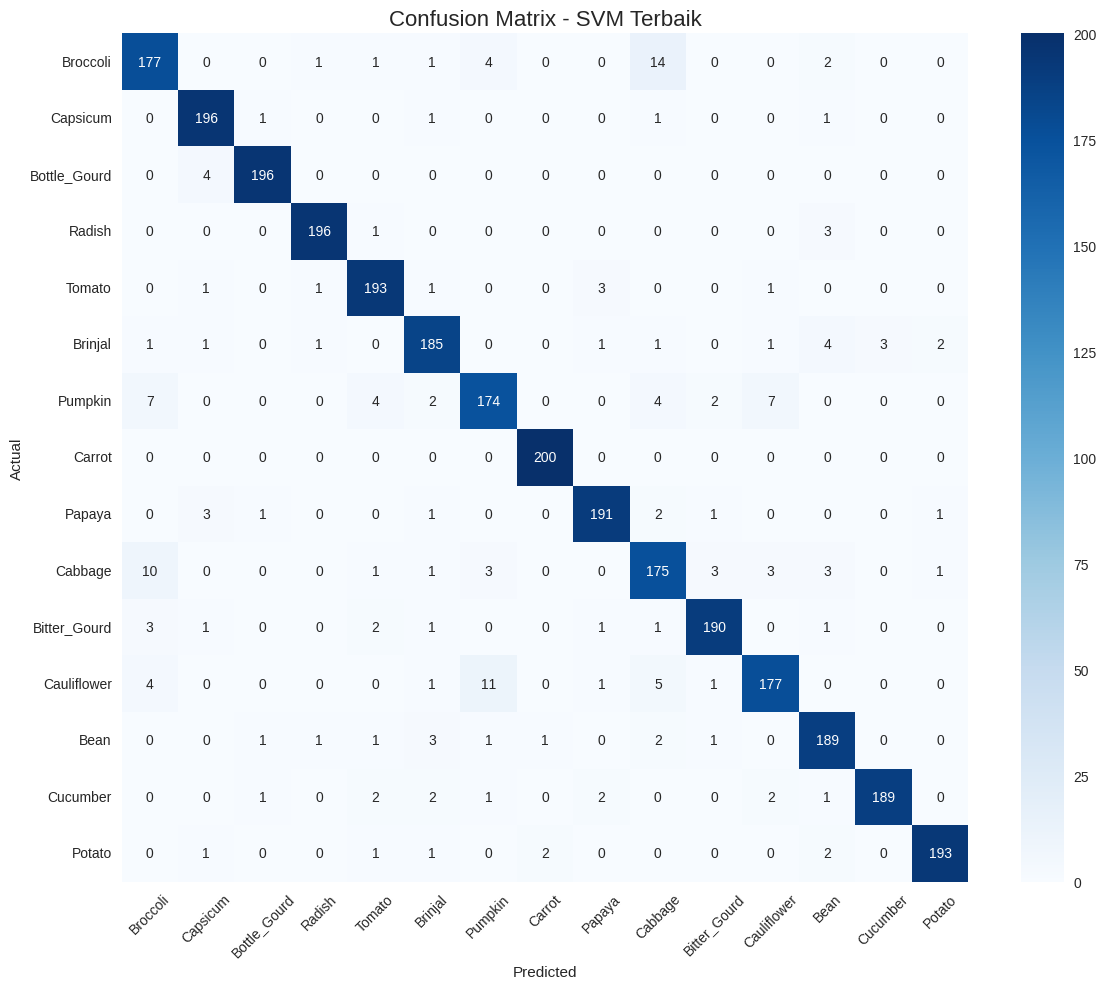

In [ ]:
# confusion matrix
cm = confusion_matrix(y_te, y_pred_best)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name} Terbaik', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_te, y_pred_best, target_names=class_names, zero_division=0))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Broccoli       0.88      0.89      0.88       200
    Capsicum       0.95      0.98      0.96       200
Bottle_Gourd       0.98      0.98      0.98       200
      Radish       0.98      0.98      0.98       200
      Tomato       0.94      0.96      0.95       200
     Brinjal       0.93      0.93      0.93       200
     Pumpkin       0.90      0.87      0.88       200
      Carrot       0.99      1.00      0.99       200
      Papaya       0.96      0.95      0.96       200
     Cabbage       0.85      0.88      0.86       200
Bitter_Gourd       0.96      0.95      0.95       200
 Cauliflower       0.93      0.89      0.91       200
        Bean       0.92      0.94      0.93       200
    Cucumber       0.98      0.94      0.96       200
      Potato       0.98      0.96      0.97       200

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
we

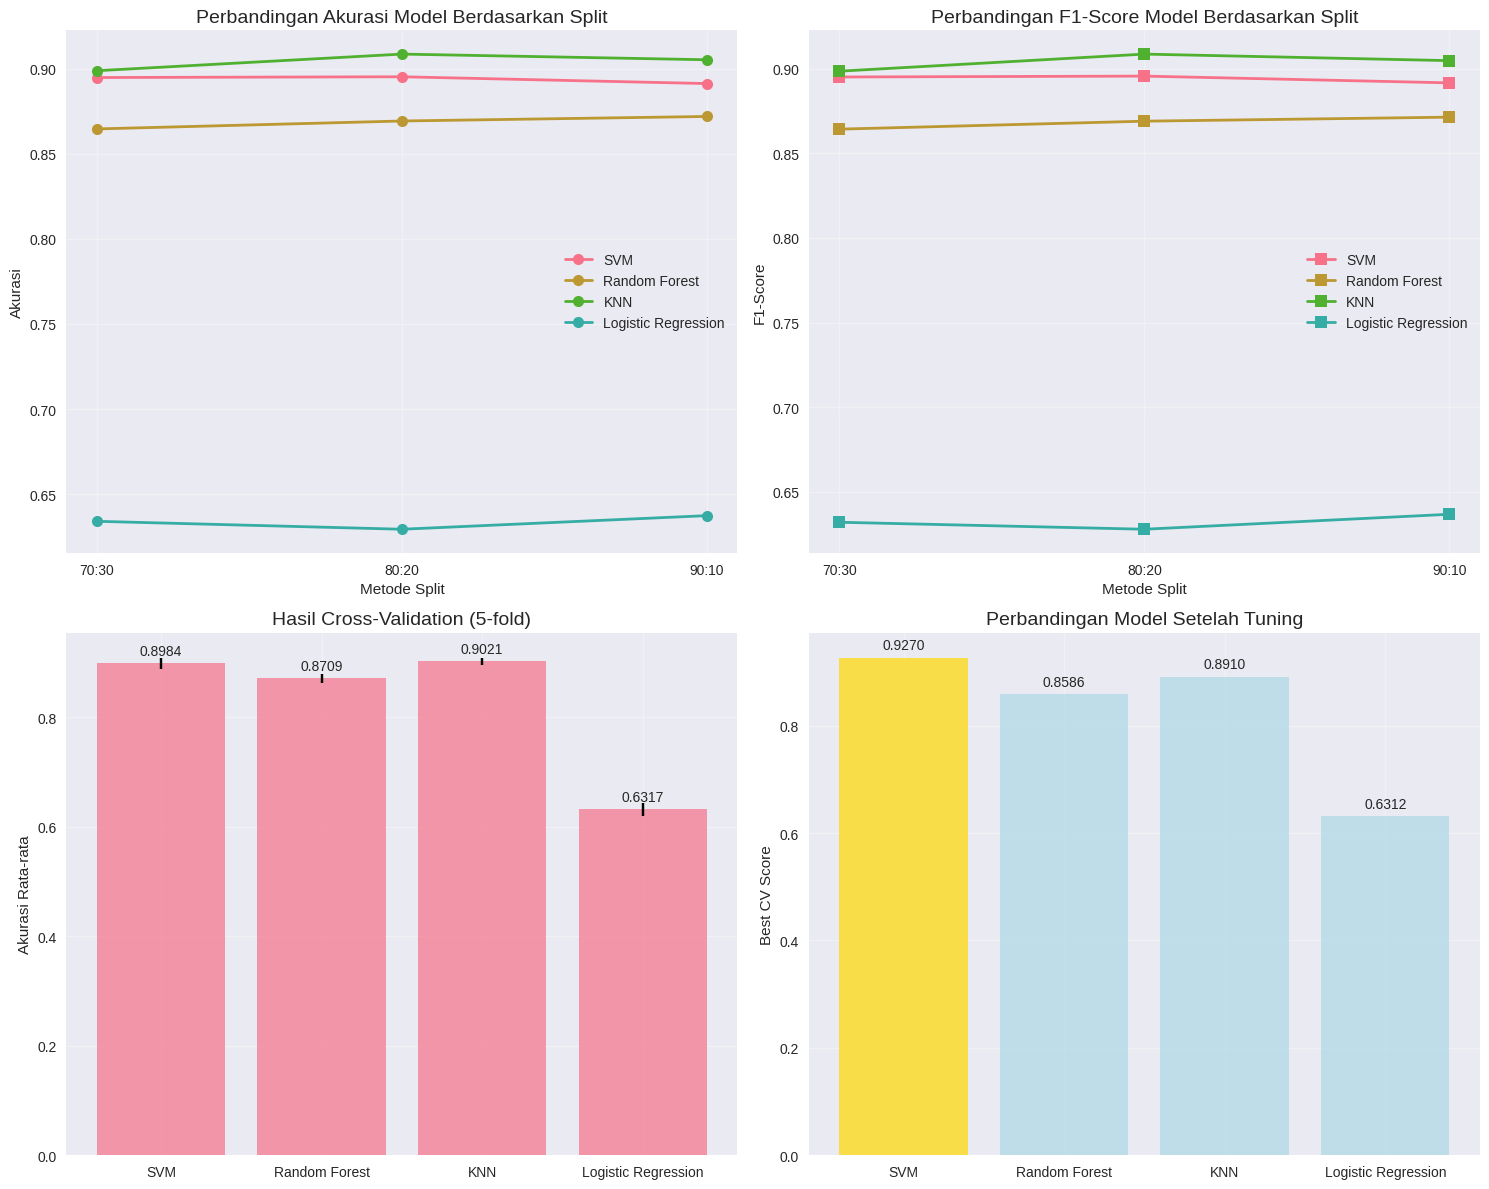

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

split_names = list(results.keys())
model_names = list(models.keys())

# akurasi per split
for model_name in model_names:
    accuracies = [results[split][model_name]['accuracy'] for split in split_names]
    axes[0,0].plot(split_names, accuracies, 'o-', linewidth=2, markersize=8, label=model_name)

axes[0,0].set_title('Perbandingan Akurasi Model Berdasarkan Split', fontsize=14)
axes[0,0].set_xlabel('Metode Split')
axes[0,0].set_ylabel('Akurasi')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# F1-Score per split
for model_name in model_names:
    f1_scores = [results[split][model_name]['f1_score'] for split in split_names]
    axes[0,1].plot(split_names, f1_scores, 's-', linewidth=2, markersize=8, label=model_name)

axes[0,1].set_title('Perbandingan F1-Score Model Berdasarkan Split', fontsize=14)
axes[0,1].set_xlabel('Metode Split')
axes[0,1].set_ylabel('F1-Score')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# cross-validation results
cv_means = [cv_results[name]['mean_accuracy'] for name in model_names]
cv_stds = [cv_results[name]['std_accuracy'] for name in model_names]

bars = axes[1,0].bar(model_names, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
axes[1,0].set_title('Hasil Cross-Validation (5-fold)', fontsize=14)
axes[1,0].set_ylabel('Akurasi Rata-rata')
axes[1,0].grid(True, alpha=0.3)

for bar, mean in zip(bars, cv_means):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{mean:.4f}', ha='center', va='bottom')

# perbandingan model terbaik
best_scores = [model_scores[name] for name in model_names]
colors = ['lightblue' if name != best_model_name else 'gold' for name in model_names]

bars = axes[1,1].bar(model_names, best_scores, color=colors, alpha=0.7)
axes[1,1].set_title('Perbandingan Model Setelah Tuning', fontsize=14)
axes[1,1].set_ylabel('Best CV Score')
axes[1,1].grid(True, alpha=0.3)

for bar, score in zip(bars, best_scores):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
summary_data = []
for split_name, split_results in results.items():
    for model_name, metrics in split_results.items():
        summary_data.append({
            'Split': split_name,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1_score'],
            'Time(s)': metrics['training_time']
        })

summary_df = pd.DataFrame(summary_data)
print("\nPerforma Model berdasarkan Split:")
print(summary_df.round(4))

print("\nCross-Validation Results:")
cv_summary = pd.DataFrame({
    'Mean Accuracy': [cv_results[name]['mean_accuracy'] for name in model_names],
    'Std Accuracy': [cv_results[name]['std_accuracy'] for name in model_names]
}, index=model_names)
print(cv_summary.round(4))

print(f"\nModel Terbaik: {best_model_name}")
print(f"Best CV Score: {best_score:.4f}")


Performa Model berdasarkan Split:
    Split                Model  Accuracy  Precision  Recall  F1-Score  Time(s)
0   70:30                  SVM    0.8949     0.8958  0.8949    0.8951   4.7279
1   70:30        Random Forest    0.8647     0.8648  0.8647    0.8643   7.0896
2   70:30                  KNN    0.8989     0.8997  0.8989    0.8985   0.3566
3   70:30  Logistic Regression    0.6340     0.6319  0.6340    0.6320   2.3698
4   80:20                  SVM    0.8953     0.8969  0.8953    0.8956   4.6916
5   80:20        Random Forest    0.8693     0.8694  0.8693    0.8690   8.0312
6   80:20                  KNN    0.9087     0.9099  0.9087    0.9086   0.2277
7   80:20  Logistic Regression    0.6293     0.6281  0.6293    0.6279   1.7591
8   90:10                  SVM    0.8913     0.8933  0.8913    0.8916   4.4305
9   90:10        Random Forest    0.8720     0.8717  0.8720    0.8714   8.6538
10  90:10                  KNN    0.9053     0.9055  0.9053    0.9048   0.1460
11  90:10  Logist

### **6. Simpan Model Terbaik**

In [ ]:
joblib.dump(best_model, 'best_vegetable_classifier.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
print("Model, scaler, dan PCA telah disimpan.")

Model, scaler, dan PCA telah disimpan.


### **7. Pengujian pada Data Test dan Validation**

Menguji model terbaik pada dataset test dan validation yang terpisah
- Evaluasi performa dengan metrik yang sama (Akurasi, Presisi, Recall, F1-Score)
- Visualization dengan confusion matrix untuk setiap dataset


In [ ]:
def evaluate_model(directory, model, scaler, pca, class_names):
    """
    Mengevaluasi model pada direktori tertentu (test atau validation)

    Parameters:
    - directory: path ke direktori dataset
    - model: model yang sudah dilatih
    - scaler: scaler yang sudah di-fit
    - pca: pca yang sudah di-fit
    - class_names: list nama kelas
    """
    all_image_paths = []
    y_true = []

    # Kumpulkan semua path gambar dan labelnya
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            all_image_paths.append(os.path.join(class_path, img_file))
            y_true.append(idx)

    y_pred = []

    # Proses setiap gambar
    for img_path in tqdm(all_image_paths, desc=f"Evaluating {os.path.basename(directory)}"):
        try:
            processed_img = preprocess_image(img_path)
            if processed_img is None:
                y_pred.append(-1)
                continue

            # Extract fitur
            feature_vector = extract_features([processed_img])[0]
            feature_vector_2d = feature_vector.reshape(1, -1)

            # Normalisasi dan PCA
            scaled_features = scaler.transform(feature_vector_2d)
            pca_features = pca.transform(scaled_features)

            # Prediksi
            prediction_index = model.predict(pca_features)[0]
            y_pred.append(prediction_index)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            y_pred.append(-1)

    # Filter out error cases
    valid_indices = [i for i, label in enumerate(y_pred) if label != -1]
    y_true_filtered = [y_true[i] for i in valid_indices]
    y_pred_filtered = [y_pred[i] for i in valid_indices]

    # Hitung metrik evaluasi
    accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
    precision = precision_score(y_true_filtered, y_pred_filtered, average='weighted', zero_division=0)
    recall = recall_score(y_true_filtered, y_pred_filtered, average='weighted', zero_division=0)
    f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted', zero_division=0)

    print(f"\n{'='*60}")
    print(f"HASIL EVALUASI: {os.path.basename(directory).upper()} DATASET")
    print(f"{'='*60}")
    print(f"Total Gambar: {len(y_true_filtered)}")
    print(f"Gambar Berhasil Diproses: {len(y_true_filtered)}")
    print(f"Gambar Gagal Diproses: {len(y_true) - len(y_true_filtered)}")
    print(f"\nMetrik Performa:")
    print(f"  Akurasi:  {accuracy:.4f}")
    print(f"  Presisi:  {precision:.4f}")
    print(f"  Recall:   {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    print("\nLaporan Klasifikasi Detail:")
    print(classification_report(y_true_filtered, y_pred_filtered, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {os.path.basename(directory).upper()} Dataset', fontsize=16, fontweight='bold')
    plt.ylabel('Label Asli (True)', fontsize=12)
    plt.xlabel('Label Prediksi (Predicted)', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'total_samples': len(y_true_filtered),
        'y_true': y_true_filtered,
        'y_pred': y_pred_filtered
    }


In [ ]:
# Load model dan components yang sudah disimpan
print("Loading model dan components...")
model_final = joblib.load('best_vegetable_classifier.pkl')
scaler_final = joblib.load('scaler.pkl')
pca_final = joblib.load('pca.pkl')
print("Model berhasil di-load!")


Loading model dan components...
Model berhasil di-load!


In [ ]:
# Tentukan path untuk test dan validation dataset
test_dir = r"/kaggle/input/vegetable-image-dataset/Vegetable Images/test"
val_dir = r"/kaggle/input/vegetable-image-dataset/Vegetable Images/validation"
# test_dir = r"D:\KULIAH 5\Pembelajaran Mesin\week 12\Vegetable Images\test"
# val_dir = r"D:\KULIAH 5\Pembelajaran Mesin\week 12\Vegetable Images\validation"

# Cek apakah directory ada
print("Checking directories...")
print(f"Test directory exists: {os.path.isdir(test_dir)}")
print(f"Validation directory exists: {os.path.isdir(val_dir)}")

if os.path.isdir(test_dir):
    print(f"\nClasses in test directory: {os.listdir(test_dir)}")
if os.path.isdir(val_dir):
    print(f"Classes in validation directory: {os.listdir(val_dir)}")


Checking directories...
Test directory exists: True
Validation directory exists: True

Classes in test directory: ['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']
Classes in validation directory: ['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']



EVALUASI PADA TEST DATASET


Evaluating test: 100%|██████████| 3000/3000 [00:56<00:00, 52.79it/s]



HASIL EVALUASI: TEST DATASET
Total Gambar: 3000
Gambar Berhasil Diproses: 3000
Gambar Gagal Diproses: 0

Metrik Performa:
  Akurasi:  0.9413
  Presisi:  0.9417
  Recall:   0.9413
  F1-Score: 0.9412

Laporan Klasifikasi Detail:
              precision    recall  f1-score   support

    Broccoli       0.87      0.91      0.89       200
    Capsicum       0.99      0.98      0.99       200
Bottle_Gourd       0.99      0.99      0.99       200
      Radish       0.96      0.98      0.97       200
      Tomato       0.89      0.96      0.93       200
     Brinjal       0.94      0.95      0.95       200
     Pumpkin       0.90      0.85      0.88       200
      Carrot       0.99      0.99      0.99       200
      Papaya       0.95      0.97      0.96       200
     Cabbage       0.87      0.87      0.87       200
Bitter_Gourd       0.98      0.96      0.97       200
 Cauliflower       0.90      0.85      0.87       200
        Bean       0.95      0.94      0.94       200
    Cucumber   

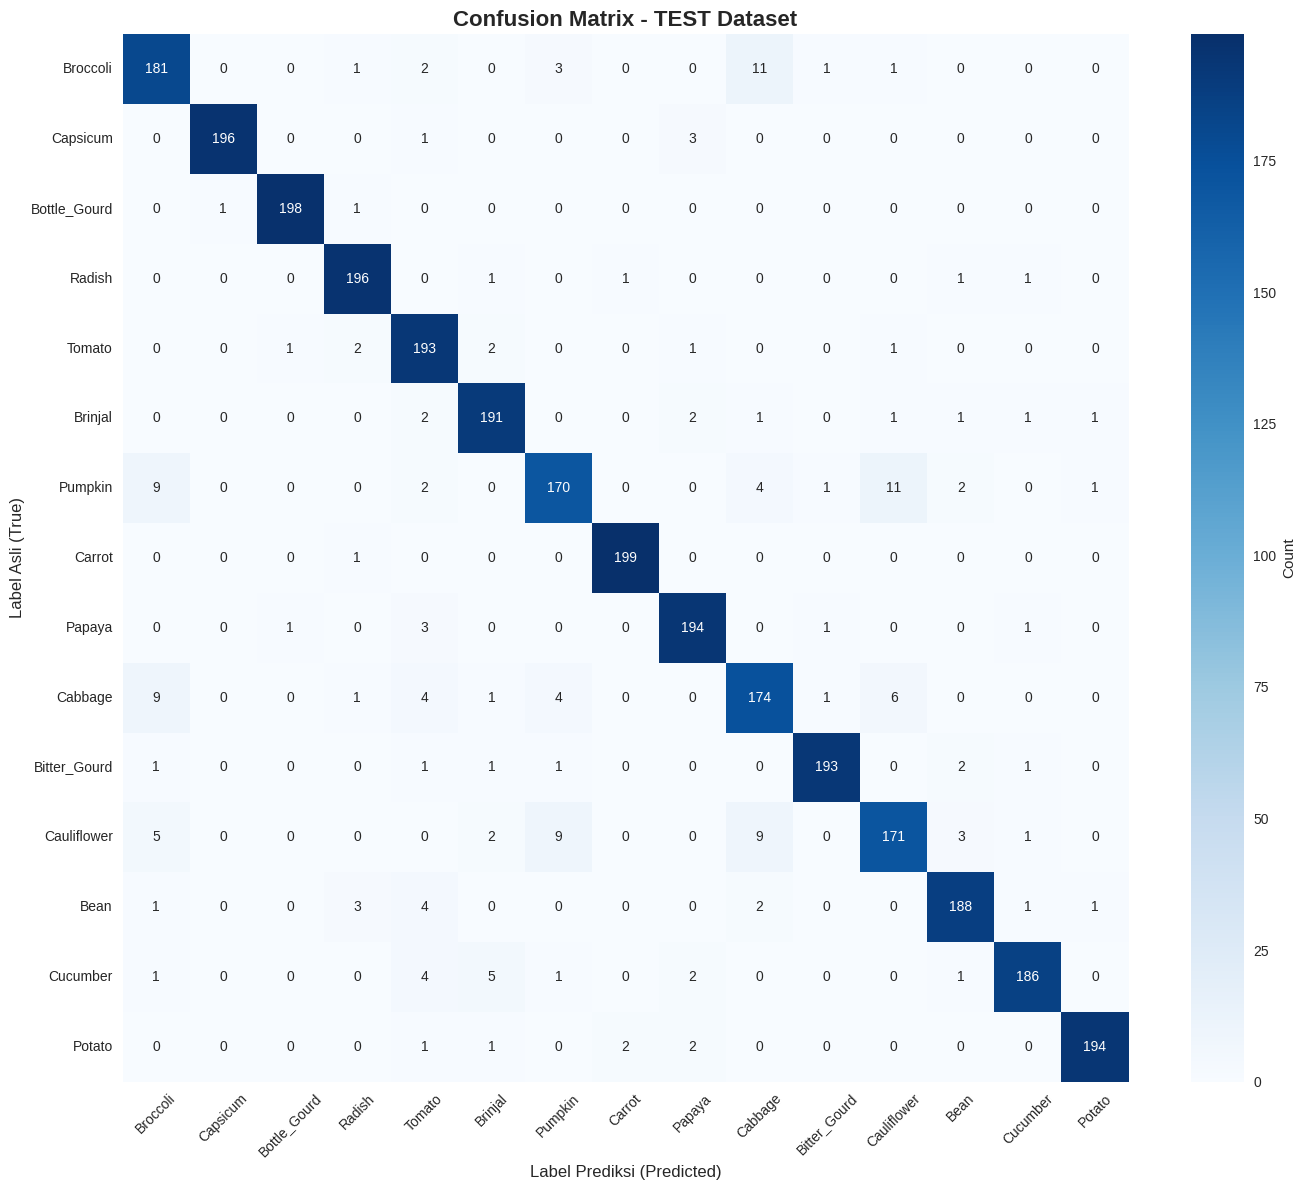

In [ ]:
# Evaluasi pada Test Dataset
if os.path.isdir(test_dir):
    print("\n" + "="*60)
    print("EVALUASI PADA TEST DATASET")
    print("="*60)
    test_results = evaluate_model(test_dir, model_final, scaler_final, pca_final, class_names)
else:
    print(f"WARNING: Test directory tidak ditemukan: {test_dir}")
    test_results = None



EVALUASI PADA VALIDATION DATASET


Evaluating validation: 100%|██████████| 3000/3000 [00:56<00:00, 52.72it/s]



HASIL EVALUASI: VALIDATION DATASET
Total Gambar: 3000
Gambar Berhasil Diproses: 3000
Gambar Gagal Diproses: 0

Metrik Performa:
  Akurasi:  0.9407
  Presisi:  0.9408
  Recall:   0.9407
  F1-Score: 0.9405

Laporan Klasifikasi Detail:
              precision    recall  f1-score   support

    Broccoli       0.89      0.94      0.91       200
    Capsicum       0.97      0.98      0.98       200
Bottle_Gourd       0.98      0.97      0.98       200
      Radish       0.96      0.96      0.96       200
      Tomato       0.93      0.97      0.95       200
     Brinjal       0.95      0.92      0.93       200
     Pumpkin       0.89      0.83      0.86       200
      Carrot       0.99      0.98      0.99       200
      Papaya       0.95      0.97      0.96       200
     Cabbage       0.86      0.89      0.88       200
Bitter_Gourd       0.95      0.98      0.97       200
 Cauliflower       0.91      0.86      0.88       200
        Bean       0.95      0.92      0.93       200
    Cucum

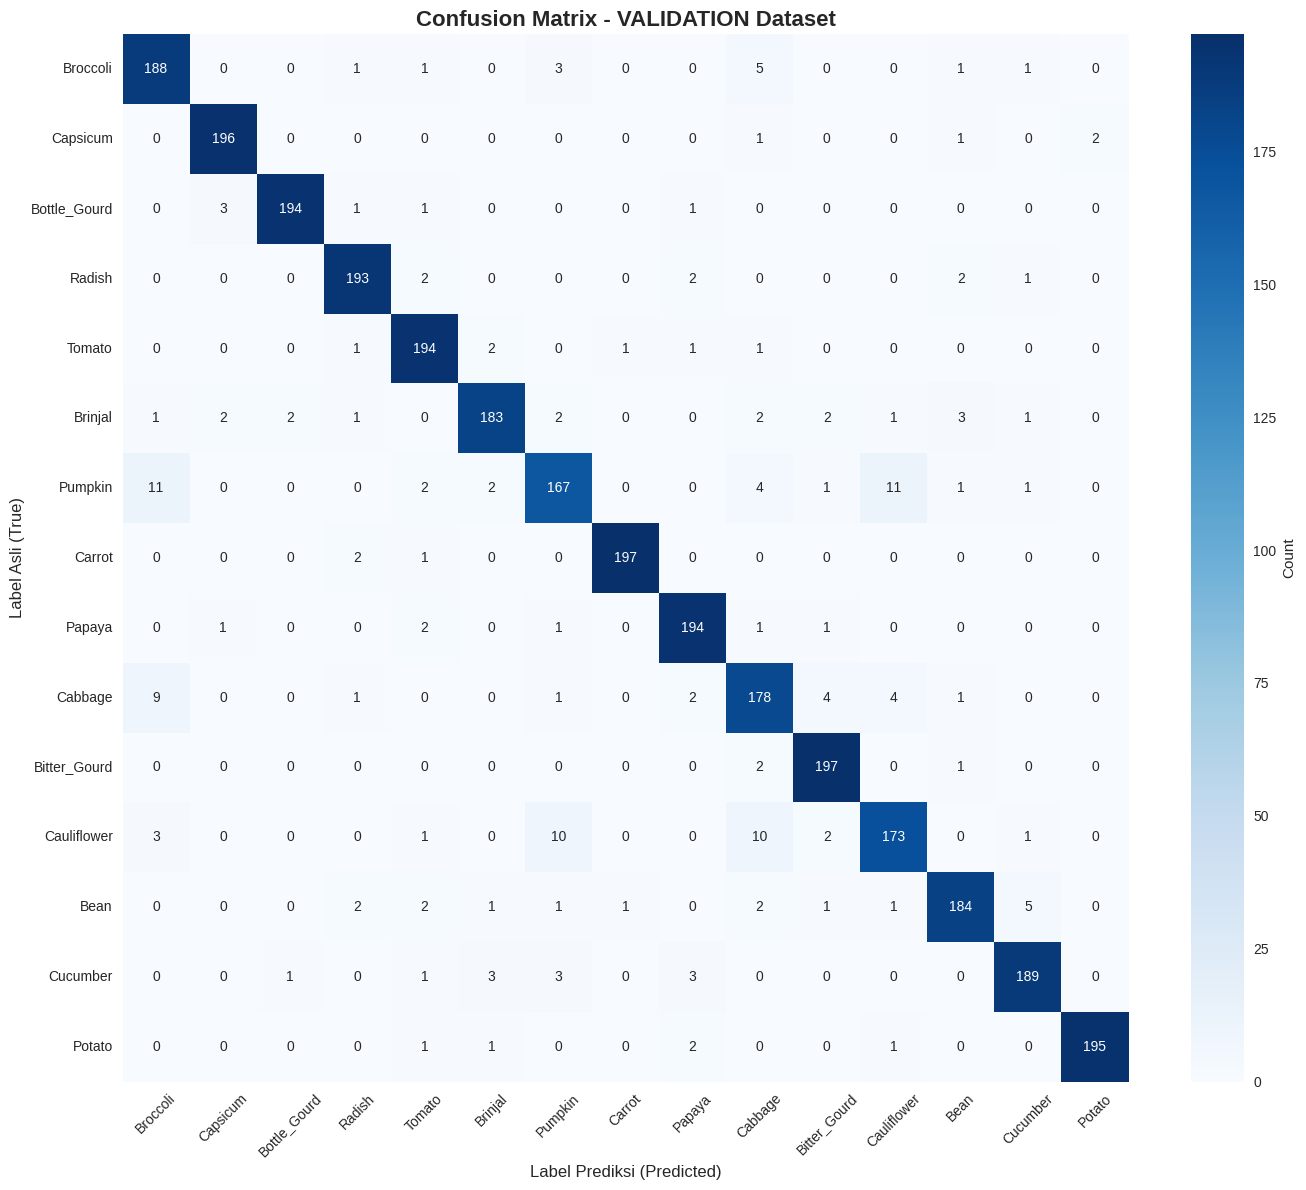

In [ ]:
# Evaluasi pada Validation Dataset
if os.path.isdir(val_dir):
    print("\n" + "="*60)
    print("EVALUASI PADA VALIDATION DATASET")
    print("="*60)
    val_results = evaluate_model(val_dir, model_final, scaler_final, pca_final, class_names)
else:
    print(f"WARNING: Validation directory tidak ditemukan: {val_dir}")
    val_results = None



RINGKASAN PERBANDINGAN HASIL EVALUASI

1. Training Data (dari 80:20 split):
   Akurasi: 0.8953

2. Test Dataset:
   Akurasi: 0.9413

3. Validation Dataset:
   Akurasi: 0.9407

TABEL PERBANDINGAN METRIK SEMUA DATASET
         Dataset  Accuracy  Precision  Recall  F1-Score
Training (80:20)    0.8953     0.8969  0.8953    0.8956
            Test    0.9413     0.9417  0.9413    0.9412
      Validation    0.9407     0.9408  0.9407    0.9405


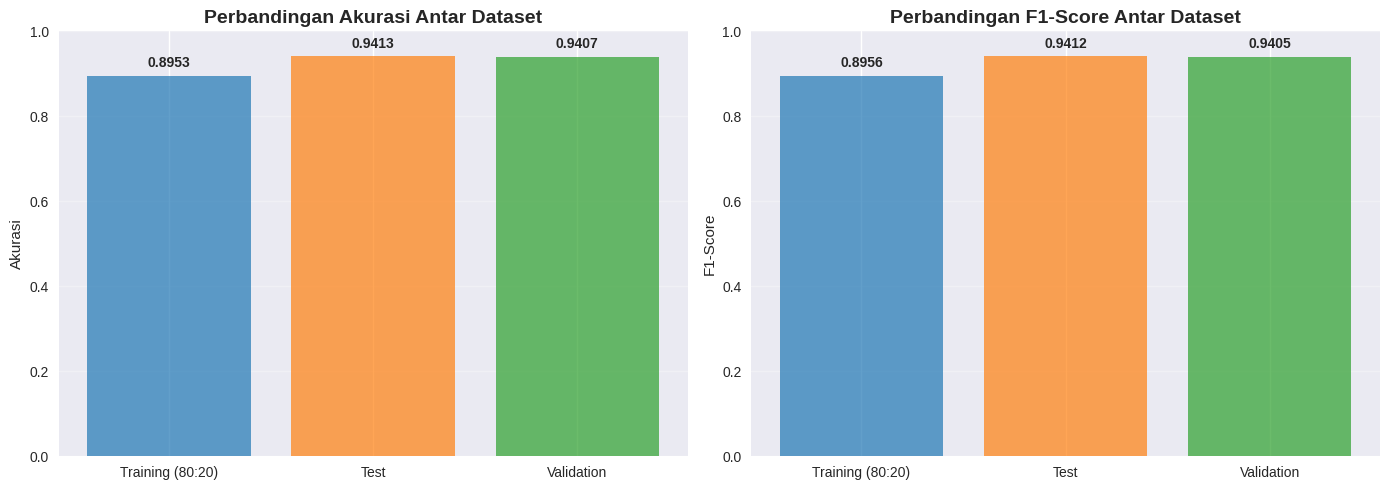

In [ ]:
# Perbandingan hasil evaluasi dari semua dataset
print("\n" + "="*60)
print("RINGKASAN PERBANDINGAN HASIL EVALUASI")
print("="*60)

comparison_data = []

# Hasil pada Training data (80:20 split)
print("\n1. Training Data (dari 80:20 split):")
print(f"   Akurasi: {results['80:20']['SVM']['accuracy']:.4f}")
comparison_data.append({
    'Dataset': 'Training (80:20)',
    'Accuracy': results['80:20']['SVM']['accuracy'],
    'Precision': results['80:20']['SVM']['precision'],
    'Recall': results['80:20']['SVM']['recall'],
    'F1-Score': results['80:20']['SVM']['f1_score']
})

# Hasil pada Test data
if test_results is not None:
    print("\n2. Test Dataset:")
    print(f"   Akurasi: {test_results['accuracy']:.4f}")
    comparison_data.append({
        'Dataset': 'Test',
        'Accuracy': test_results['accuracy'],
        'Precision': test_results['precision'],
        'Recall': test_results['recall'],
        'F1-Score': test_results['f1_score']
    })

# Hasil pada Validation data
if val_results is not None:
    print("\n3. Validation Dataset:")
    print(f"   Akurasi: {val_results['accuracy']:.4f}")
    comparison_data.append({
        'Dataset': 'Validation',
        'Accuracy': val_results['accuracy'],
        'Precision': val_results['precision'],
        'Recall': val_results['recall'],
        'F1-Score': val_results['f1_score']
    })

# Buat tabel perbandingan
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*60)
    print("TABEL PERBANDINGAN METRIK SEMUA DATASET")
    print("="*60)
    print(comparison_df.round(4).to_string(index=False))

    # Visualisasi perbandingan
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy comparison
    axes[0].bar(comparison_df['Dataset'], comparison_df['Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
    axes[0].set_title('Perbandingan Akurasi Antar Dataset', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Akurasi')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(comparison_df['Accuracy']):
        axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

    # F1-Score comparison
    axes[1].bar(comparison_df['Dataset'], comparison_df['F1-Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
    axes[1].set_title('Perbandingan F1-Score Antar Dataset', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('F1-Score')
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(comparison_df['F1-Score']):
        axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()
